# NetColoc analysis of rare variants in Autism spectrum disorder (ASD) and Congenital Heart Disease (CHD)

Example of NetColoc workflow on genes associated with rare exome variants in ASD and CHD

**Some background:**

Here we introduce NetColoc, a tool which evaluates the extent to which two gene sets are related in network space, i.e. the extent to which they are colocalized in a molecular interaction network, and interrogates the underlying biological pathways and processes using multiscale community detection. This framework may be applied to any number of scenarios in which gene sets have been associated with a phenotype or condition, including rare and common variants within the same disease, genes associated with two comorbid diseases, genetically correlated GWAS phenotypes, GWAS across two different species, or gene expression changes after treatment with two different drugs, to name a few. NetColoc relies on a dual network propagation approach to identify the region of network space which is significantly proximal to both input gene sets, and as such is highly effective for small to medium input gene sets.



# _Obtain input gene sets and interactome_

## 1. Load required packages

In [1]:
# load required packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import re
import random

from IPython.display import display

import getpass
import ndex2

import json
import cdapsutil

from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

from scipy.stats import hypergeom
from scipy.stats import norm

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

from datetime import datetime
import sys
%matplotlib inline

In [2]:
from netcoloc import netprop_zscore, netprop, network_colocalization, validation


## 2. Select two gene sets of interest. Load gene sets from text files into python.


Identify two gene sets of interest. Gene sets should come from experimental data (not manual curation) to avoid bias. 

**Usage Note**: gene sets should be < 500 genes (propagation algorithm breaks down if seeded with larger sets). If your gene set is larger, only use the top 500 as seeds to the network propagation.



In [4]:
# set names of geneset 1 and geneset 2
# ------ customize this section based on your gene sets and how they should be labeled -------
d1_name='ASD'
d2_name='CHD'

In [5]:
# ------ customize this section based your input genesets -------

# load rare variants Satterstrom et al 2020; PMID: 31981491
D1_df = pd.read_csv('data/Satterstrom--Top-102-ASD-genes--May2019.csv')
D1_df.index = D1_df['gene']
print('Number of '+d1_name+' genes:', len(D1_df))
D1_genes = D1_df.index.tolist() # define rare variant genes to seed network propagation
print("First 5 genes:", D1_genes[0:5])

Number of ASD genes: 102
First 5 genes: ['CHD8', 'SCN2A', 'SYNGAP1', 'ADNP', 'FOXP1']


In [6]:
# ------ customize this section based your input genesets -------

# load D2 rare variant genes from Jin et al 2017; PMID: 28991257
D2_df = pd.read_csv('data/CHD_HC.tsv',sep='\t')
D2_genes = D2_df['0'].tolist()
print('Number of '+d2_name+' genes:',len(D2_genes))
print('First 5 genes:', D2_genes[0:5])

Number of CHD genes: 66
First 5 genes: ['KMT2D', 'CHD7', 'PTPN11', 'NSD1', 'NOTCH1']


In [7]:
# Output the overlap between the two gene sets
print('Number of '+d1_name+' and '+d2_name+' genes overlapping:', len(np.intersect1d(D1_genes,D2_genes)))

# Create a dictionary for each geneset
seed_dict = {d1_name:D1_genes,d2_name:D2_genes}


Number of ASD and CHD genes overlapping: 6


## 3. Select gene interaction network to use for the analysis.

Identify network UUID on NDEx (ndexbio.org) and use this to import to this Jupyter notebook. We recommend using PCNet as a starting point, but a user may want to switch to “STRING high confidence” if using a machine with low memory (< 8GB RAM).


In [8]:
interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
# interactome_uuid='275bd84e-3d18-11e8-a935-0ac135e8bacf' # for STRING high confidence
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_int = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_int.nodes)

# remove self edges from network
G_int.remove_edges_from(nx.selfloop_edges(G_int))

# print out the numbers of nodes and edges in the interatome for diagnostic purposes:
print('Number of nodes:', len(G_int.nodes))
print('\nNumber of edges:', len(G_int.edges))

Number of nodes: 18820

Number of edges: 2693109


In [9]:
int_nodes = list(G_int.nodes)

# _Identify network colocalized gene network_

## 4. Precalculate matrices needed for propagation. This step should take a few minutes (more for larger/denser networks) 

A benchmarking analysis demonstrates that the runtime required scales with the number of edges (w’) and the number of nodes (w’’). NetColoc includes functionality for saving and loading these matrices, by setting the XXX parameter, which can be useful if running multiple analyses. The diffusion parameter, which controls the rate of propagation through the network, may be set in this step. In practice, we have found that results are not dependent on the choice of this parameter, and recommend using the default value of 0.5.

Background on network propagation: https://www.nature.com/articles/nrg.2017.38.pdf?origin=ppub


In [10]:
# pre-calculate matrices used for network propagation. this step takes a few minutes, more for denser interactomes
print('\ncalculating w_prime')
w_prime = netprop.get_normalized_adjacency_matrix(G_int, conserve_heat=True)

print('\ncalculating w_double_prime')
w_double_prime = netprop.get_individual_heats_matrix(w_prime, .5)

# w_double_prime can be saved to the file netcoloc_w_double_prime.npy
# in current working directory with the following call:
#
# np.save('netcoloc_w_double_prime.npy', w_double_prime)

# and reloaded later with:
# w_double_prime = np.load('netcoloc_w_double_prime.npy')
#
# NOTE: Saving w_double_prime results in a several gigabyte file and
#       takes a minute or more to save and load



calculating w_prime

calculating w_double_prime


## 5. Subset seed genes to those found in the selected network. 

Only genes contained in the interaction network will be retained for downstream analysis. 


In [11]:
# subset seed genes to those found in interactome
print("Number of D1 genes:", len(D1_genes))
D1_genes = list(np.intersect1d(D1_genes,int_nodes))
print("Number of D1 genes in interactome:", len(D1_genes))

print("Number of D2 genes:", len(D2_genes))
D2_genes = list(np.intersect1d(D2_genes,int_nodes))
print("Number of D2 genes in interactome:", len(D2_genes))


Number of D1 genes: 102
Number of D1 genes in interactome: 96
Number of D2 genes: 66
Number of D2 genes in interactome: 60


## 6. Compute network proximity scores from both seed gene sets independently.

The network proximity scores include a correction for the degree distribution of the input gene sets. The runtime required for computing the network proximity scores increases linearly with the number of nodes in the underlying interaction network and with the size of the input gene list

In [12]:
# D1 network propagation
print('\nCalculating D1 z-scores: ')
z_D1, Fnew_D1, Fnew_rand_D1 = netprop_zscore.calculate_heat_zscores(w_double_prime, int_nodes, 
                                                                    dict(G_int.degree), 
                                                                    D1_genes, num_reps=1000,
                                                                    minimum_bin_size=100)

z_D1 = pd.DataFrame({'z':z_D1})

z_D1.sort_values('z',ascending=False).head()


Calculating D1 z-scores: 


  0%|          | 0/1000 [00:00<?, ?it/s]

,z
TRIP12,23.674264
NUP155,20.643715
ADNP,20.489814
TLK2,19.532815
CREBBP,18.945873


In [13]:
# D2 network propagation
print('\nCalculating D2 z-scores: ')
z_D2, Fnew_D2, Fnew_rand_D2 = netprop_zscore.calculate_heat_zscores(w_double_prime, int_nodes, 
                                                                    dict(G_int.degree), 
                                                                    D2_genes, num_reps=1000,
                                                                    minimum_bin_size=100)

z_D2 = pd.DataFrame({'z':z_D2})
z_D2.sort_values('z',ascending=False).head()


Calculating D2 z-scores: 


  0%|          | 0/1000 [00:00<?, ?it/s]

,z
ACTB,25.046474
RPL5,24.320330
SMAD2,22.308273
U2SURP,22.132597
NAA15,20.724822


## 7. Build NetColoc subnetwork and evaluate for significant network colocalization. 

To build the NetColoc subnetwork we take the product of the two proximity vectors as follows:

$z_{coloc}=z_1 \times z_2$  

We then select genes for which $z_{coloc}$ is greater than a threshold ($z_{coloc}>3$ here, but can be set by the user), and the network proximity scores were individually larger than a nominal threshold ($z_1>1.5$, and $z_2>1.5$ here, but can be set by the user). The subnetwork comprising the genes and interactions meeting these criteria make up the network colocalization subnetwork. 

The authors have found that the default threshold values work well in practice, to find the set of genes which is proximal to both seed gene sets. Tuning them higher will lead to fewer false positives, but more false negatives. Similarly, tuning them lower will lead to more false positives, but fewer false negatives. Either may be warranted given the specifics of an experiment. 

The researcher may conduct a sensitivity analysis of these thresholds to select to find a balance between higher NetColoc enrichment score, but smaller network, and lower NetColoc enrichment score, but larger network. The function ‘network_colocalization.calculate_network_enrichment’ is provided to enable such a sensitivity analysis. In this function, the network colocalization score is computed for the gene set pair, based on the observed network overlap and expected network overlap, over a range of z-score thresholds. 

If gene sets are significantly colocalized, proceed with analysis. Gene sets which are not significantly colocalized in the network have no evidence for shared underlying pathways, and thus proceeding with analysis of the network intersection in this case is not likely to return meaningful results.



In [14]:
zlist = [2,3,4,5,9,12]
z12list = [1,1.5,2]
netcoloc_enrichment_df = network_colocalization.calculate_network_enrichment(z_D1,z_D2,
                                                                             zthresh_list = zlist,
                                                                             z12thresh_list=z12list,
                                                                             verbose=True)
netcoloc_enrichment_df.head()

z = 2
z12 = 1
size of network intersection = 1307
observed size/ expected size = 2.3143393419980876
p = 0.0
z = 2
z12 = 1.5
size of network intersection = 814
observed size/ expected size = 2.904135003032573
p = 0.0
z = 2
z12 = 2
size of network intersection = 380
observed size/ expected size = 3.829101168883515
p = 6.810624208336245e-199
z = 3
z12 = 1
size of network intersection = 985
observed size/ expected size = 2.531547970906474
p = 0.0
z = 3
z12 = 1.5
size of network intersection = 773
observed size/ expected size = 2.9758238373883588
p = 0.0
z = 3
z12 = 2
size of network intersection = 380
observed size/ expected size = 3.8156441409780095
p = 6.633640972834342e-204
z = 4
z12 = 1
size of network intersection = 708
observed size/ expected size = 2.780723459408507
p = 5.810073683764967e-230
z = 4
z12 = 1.5
size of network intersection = 632
observed size/ expected size = 3.1502342737513707
p = 3.1948121403884235e-222
z = 4
z12 = 2
size of network intersection = 380
observed size/ 

,z_comb,z_12,observed_overlap,expected_overlap_mean,expected_overlap_std,empirical_p,obs_exp
0,2,1.0,1307,564.74,16.902438,0.000000e+00,2.314339
1,2,1.5,814,280.29,13.268229,0.000000e+00,2.904135
2,2,2.0,380,99.24,9.338223,6.810624e-199,3.829101
3,3,1.0,985,389.09,15.185582,0.000000e+00,2.531548
4,3,1.5,773,259.76,12.886520,0.000000e+00,2.975824


### Select z thresholds, and plot the sizes of the observed and expected NetColoc subnetworks.

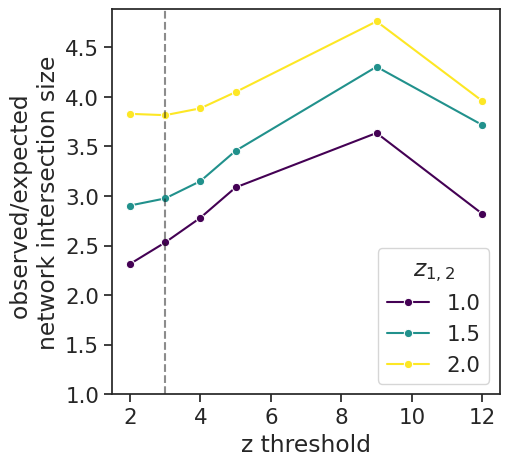

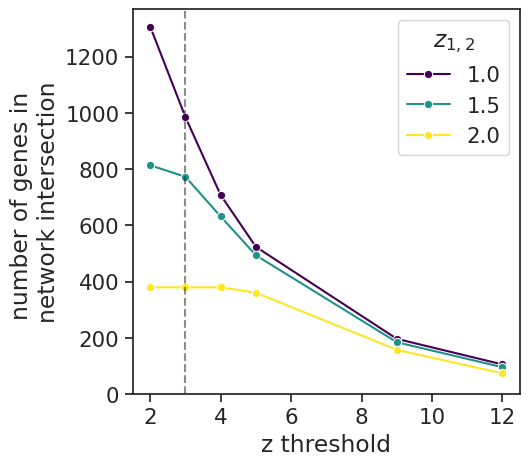

In [15]:
plt.figure(figsize=(5,5))
sns.lineplot(x='z_comb',y='obs_exp',data=netcoloc_enrichment_df,hue='z_12',style='z_12',
            markers=['o','o','o'],dashes=False,palette='viridis')
ylim_max=plt.gca().get_ylim()[1]
plt.ylim([1,ylim_max])
plt.plot([3,3],[1,ylim_max],'k--',alpha=.5)

plt.xlabel('z threshold')
plt.ylabel('observed/expected \nnetwork intersection size')
plt.legend(title="$z_{1,2}$")

plt.figure(figsize=(5,5))
sns.lineplot(x='z_comb',y='observed_overlap',data=netcoloc_enrichment_df,hue='z_12',style='z_12',
            markers=['o','o','o'],dashes=False,palette='viridis')

ylim_max=plt.gca().get_ylim()[1]
plt.ylim([0,ylim_max])
plt.plot([3,3],[0,ylim_max],'k--',alpha=.5)

plt.xlabel('z threshold')
plt.ylabel('number of genes in \nnetwork intersection')
plt.legend(title="$z_{1,2}$")

(-1.0, 2.0)

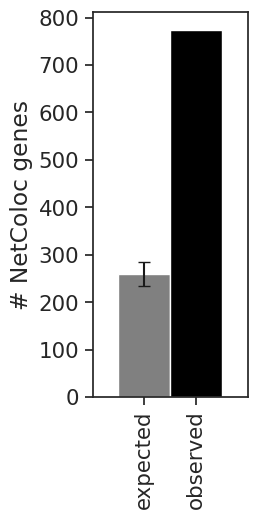

In [16]:
# ----------- select thresholds for NetColoc -----------------
zthresh=3 # default = 3
z12_thresh=1.5 # default = 1.5
# ------------------------------------------------------------

focal_netcoloc_enrichment = netcoloc_enrichment_df[(netcoloc_enrichment_df['z_comb']==zthresh) & \
                                                   (netcoloc_enrichment_df['z_12']==z12_thresh)].iloc[0]

# plot the observed and expected overlaps
plt.figure(figsize=(2,5))
plt.bar([0,1],[focal_netcoloc_enrichment['expected_overlap_mean'],
               focal_netcoloc_enrichment['observed_overlap']],color=['gray','black'],width=1)
plt.errorbar([0],[focal_netcoloc_enrichment['expected_overlap_mean']],
             [2*focal_netcoloc_enrichment['expected_overlap_std']],color='k',capsize=4)
plt.ylabel('# NetColoc genes')
plt.xticks([0,1],['expected','observed'],rotation='vertical')
plt.xlim([-1,2])

### Build network colocalization subnetwork based on selected thresholds

In [17]:
# select the genes in the network intersection, make a subgraph

G_overlap = network_colocalization.calculate_network_overlap_subgraph(G_int,z_D1['z'],z_D2['z'],z_score_threshold=zthresh,
                                                                     z1_threshold=z12_thresh,z2_threshold=z12_thresh)
print("Nodes in overlap subgraph:", len(G_overlap.nodes()))
print("Edges in overlap subgraph:", len(G_overlap.edges()))

Nodes in overlap subgraph: 773
Edges in overlap subgraph: 26351


## 8. Transform NetColoc subnetwork edges to cosine similarities (OPTIONAL)

Transform NetColoc subnetwork edges to cosine similarities, with the function ‘network_colocalization.transform_edges’. The cosine similarity score between two genes represents the extent to which those genes have similar interactors. In practice, the cosine similarity transformed score helps to visually reveal the underlying clustering structure present in a network. 



In [20]:
G_cosSim=network_colocalization.transform_edges(G_overlap,method='cosine_sim',edge_weight_threshold=0.95)

# _Compute network colocalized systems map_

## 9. Convert network colocalization subnetwork to form used in community detection module

In [21]:
# compile dataframe of metadata for overlapping nodes
node_df = pd.DataFrame(index=list(G_overlap.nodes))
node_df = node_df.assign(d1_seeds=0, d2_seeds=0, d1_name=d1_name, d2_name=d2_name)
node_df.loc[list(np.intersect1d(seed_dict[d1_name],node_df.index.tolist())), 'd1_seeds']=1
node_df.loc[list(np.intersect1d(seed_dict[d2_name],node_df.index.tolist())), 'd2_seeds']=1
node_df['z_d1']=z_D1.loc[list(G_overlap.nodes)]['z']
node_df['z_d2']=z_D2.loc[list(G_overlap.nodes)]['z']
node_df['z_both']=node_df['z_d1']*node_df['z_d2']
node_df['sum_seeds']=node_df['d1_seeds']+node_df['d2_seeds']

node_df = node_df.sort_values('z_both',ascending=False)
node_df.head(15)

,d1_seeds,d2_seeds,d1_name,d2_name,z_d1,z_d2,z_both,sum_seeds
PTEN,1,1,ASD,CHD,17.775818,18.270646,324.775666,2
CTNNB1,1,1,ASD,CHD,15.369891,16.212593,249.185790,2
POGZ,1,1,ASD,CHD,12.518539,13.035299,163.182897,2
KMT2C,1,1,ASD,CHD,12.964197,12.579514,163.083297,2
NSD1,1,1,ASD,CHD,12.263667,12.748115,156.338630,2
KDM5B,1,1,ASD,CHD,12.795978,11.553692,147.840781,2
CHD4,0,1,ASD,CHD,4.485093,17.863170,80.117979,1
KMT2A,0,1,ASD,CHD,4.267999,16.113881,68.774032,1
CDK13,0,1,ASD,CHD,4.335774,15.374536,66.660517,1
KDM5A,0,1,ASD,CHD,4.980719,13.264934,66.068913,1


## 10. Run community detection on NetColoc subnetwork (recommend HiDef).

Documentation for CDAPS utils to build multiscale systems map in notebook

https://cdapsutil.readthedocs.io/en/latest/quicktutorial.html#example  
https://cdapsutil.readthedocs.io/en/latest/cdapsutil.html#community-detection  

In [22]:
print("Nodes in overlap subgraph:", len(G_overlap.nodes()))
print("Edges in overlap subgraph:", len(G_overlap.edges()))
# Create cx format of overlap subgraph
G_overlap_cx = ndex2.create_nice_cx_from_networkx(G_overlap)
G_overlap_cx.set_name(d1_name+'_'+d2_name+'_NetColoc_subgraph') 
for node_id, node in G_overlap_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_overlap_cx.set_node_attribute(node_id, row, value, type=data_type)

cd = cdapsutil.CommunityDetection()

# Run HiDeF on CDAPS REST service
G_hier_cd = cd.run_community_detection(G_overlap_cx, algorithm='hidefv1.1beta',arguments={'--maxres':'20'})

Nodes in overlap subgraph: 773
Edges in overlap subgraph: 26351


In [23]:
# Print information about hierarchy
print('Hierarchy name: ' + str(G_hier_cd.get_name()))
print('# nodes: ' + str(len(G_hier_cd.get_nodes())))
print('# edges: ' + str(len(G_hier_cd.get_edges())))

Hierarchy name: hidefv1.1beta_(none)_ASD_CHD_NetColoc_subgraph
# nodes: 81
# edges: 85


In [24]:
# sr = cdapsutil.ServiceRunner()
# sr.get_algorithms() # this will print out available options for each algorithm

## 11. Convert the NetColoc hierarchy to networkx format, and write out features of the hierarchy to a pandas dataframe, for easier access in Python.


In [25]:
G_hier = G_hier_cd.to_networkx(mode='default')
G_hier

nodes = G_hier.nodes()

# print the number of nodes and edges in the hierarchy for diagnostic purposes
print('Number of nodes:', len(G_hier.nodes()))

print('\nNumber of edges:', len(G_hier.edges()))


Number of nodes: 81

Number of edges: 85


In [29]:
# add node attributes to dataframe for easier access
hier_df = pd.DataFrame.from_dict(dict(G_hier.nodes(data=True)), orient='index')
hier_df['system_ID']=hier_df.index.tolist()
# some columns are not the right type
hier_df['CD_MemberList_Size']=[int(x) for x in hier_df['CD_MemberList_Size'].tolist()]
hier_df['HiDeF_persistence']=[int(x) for x in hier_df['HiDeF_persistence'].tolist()]
hier_df.head()

,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,represents,name,system_ID
0,AKAP10 HIST4H4 PDCD4 AFF1 LCOR BRD1 UBXN7 CASQ...,770,False,9.589,,,0,0.0,0.0,130,C773,C773,0
1,TCF7L2 HIST4H4 NR5A2 MEIS1 KDM2B CTNNB1 BRD1 C...,273,False,8.093,,,0,0.0,0.0,6,C774,C774,1
2,OGA ZNF217 AKAP10 MYO9A N4BP2L2 MAML1 UBN2 WNK...,241,False,7.913,,,0,0.0,0.0,13,C775,C775,2
3,CHRNB1 PTPRT PRKCE ANK3 TENM4 CASQ2 AKAP6 DSCA...,165,False,7.366,,,0,0.0,0.0,86,C777,C777,3
4,TCF7L2 PDCD4 NR5A2 MEIS1 CTNNB1 PBX1 FOXD3 NR6...,109,False,6.768,,,0,0.0,0.0,12,C779,C779,4


Annotate the systems with seed gene information

In [34]:
hier_df.index=hier_df['name']
hier_df.head()

num_d1_seeds, num_d2_seeds, num_both_seeds = [],[],[]
frac_d1_seeds, frac_d2_seeds, frac_both_seeds=[],[],[]

systems_with_seeds = []
for c in hier_df.index.tolist():
    system_genes = hier_df['CD_MemberList'].loc[c].split(' ')
    d1_temp = list(np.intersect1d(system_genes,seed_dict[d1_name]))
    d2_temp = list(np.intersect1d(system_genes,seed_dict[d2_name]))
    num_d1_temp = len(d1_temp)
    num_d2_temp = len(d2_temp)
    if (num_d1_temp+num_d2_temp)>0: # keep the system if it has at least 1 seed gene
        systems_with_seeds.append(c)
        num_both_temp = len(np.intersect1d(d1_temp,d2_temp))
        num_both_seeds.append(num_both_temp)
        num_d1_seeds.append(num_d1_temp-num_both_temp)
        num_d2_seeds.append(num_d2_temp-num_both_temp)
        
        frac_both_seeds.append(num_both_temp/float(len(system_genes)))
        frac_d1_seeds.append((num_d1_temp-num_both_temp)/float(len(system_genes)))
        frac_d2_seeds.append((num_d2_temp-num_both_temp)/float(len(system_genes)))
    else:
        for stat in [num_both_seeds, num_d1_seeds, num_d2_seeds, frac_both_seeds, 
                    frac_d1_seeds, frac_d2_seeds]:
            stat.append(0)
        
        
frac_no_seeds = np.subtract(1.0,np.array([frac_d1_seeds,frac_d2_seeds,frac_both_seeds]).sum(axis=0))


hier_df['num_d1_seeds']=num_d1_seeds
hier_df['num_d2_seeds']=num_d2_seeds
hier_df['num_both_seeds']=num_d2_seeds
hier_df['frac_d1_seeds']=frac_d1_seeds
hier_df['frac_d2_seeds']=frac_d2_seeds
hier_df['frac_both_seeds']=frac_both_seeds
hier_df['frac_no_seeds']=frac_no_seeds
    

## 12. Remove systems with no seed genes (OPTIONAL)

In [ ]:
hier_df = hier_df.loc[systems_with_seeds]
print("Number of nodes with seed genes:", len(hier_df))

# prune G_hier--> only keep systems with at least one seed gene

nkeep=[]
for n in list(G_hier.nodes()):
    if G_hier.nodes(data=True)[n]['name'] in systems_keep:
        nkeep.append(n)
        

G_hier = nx.subgraph(G_hier, nkeep)
print("Number of nodes with seed genes:", len(G_hier.nodes()))
print("Number of edges remaining:", len(G_hier.edges()))

## 13. Sneak peek of hierarchy visualization (OPTIONAL)

In [65]:
network_colocalization.view_G_hier(G_hier)

CytoscapeWidget(cytoscape_layout={'name': 'cose'}, cytoscape_style=[{'selector': 'node', 'css': {'content': 'd…

## 14. Annotate systems with gprofiler. 

Annotate moderately sized systems (between 50 to 1000 genes per system) if they are significantly enriched for a Gene Ontology biological process. Also require that the GO term is enriched with $p<10^{-5}$ and shares at least 3 genes with the system to annotate, to increase the stringency of the annotation. Label the system using the GO term that meets these criteria, and has the highest sum of precision and recall. Systems which have no GO terms meeting these criteria are labeled with their unique system ID.


In [36]:
# gprofiler annotation of clusters

system_name_list = []
for p in hier_df.index.tolist():
    focal_genes=hier_df['CD_MemberList'].loc[p].split(' ')
    print(p)
    print(len(focal_genes))
    if len(focal_genes)>2:
        gp_temp = pd.DataFrame(gp.profile(focal_genes,significance_threshold_method='fdr',
                                               sources=['REAC']))
        if len(gp_temp)>0: # make sure data is not empty
            
            # make sure terms are specific, and overlap with at least 3 genes
            gp_temp = gp_temp[(gp_temp['term_size']<1000)&(gp_temp['term_size']>50)]
            gp_temp = gp_temp[gp_temp['intersection_size']>=3]
            
            gp_temp = gp_temp[gp_temp['p_value']<1E-5] # set a stringent pvalue threshold
            
            gp_temp = gp_temp.sort_values('recall',ascending=False)
            
            if len(gp_temp)>1:
                system_name_list.append(gp_temp.head(1)['name'].tolist()[0])
            else:
                system_name_list.append(p)
        else:
            system_name_list.append(p)
            

        display(gp_temp.head())
        
    else:
        system_name_list.append(p)

C773
770


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
10,PKMTs methylate histone lysines,10842,25,PKMTs methylate histone lysines,REAC:R-HSA-3214841,9.595674e-16,[REAC:R-HSA-3247509],0.056561,query_1,442,0.357143,True,REAC,70
1,Chromatin modifying enzymes,10842,89,Chromatin modifying enzymes,REAC:R-HSA-3247509,5.874388e-55,[REAC:R-HSA-4839726],0.201357,query_1,442,0.327206,True,REAC,272
0,Chromatin organization,10842,89,Chromatin organization,REAC:R-HSA-4839726,5.874388e-55,[REAC:0000000],0.201357,query_1,442,0.327206,True,REAC,272
23,Gastrulation,10842,16,Gastrulation,REAC:R-HSA-9758941,4.775804e-09,[REAC:R-HSA-1266738],0.036199,query_1,442,0.307692,True,REAC,52
17,Transcriptional Regulation by MECP2,10842,18,Transcriptional Regulation by MECP2,REAC:R-HSA-8986944,5.070951e-10,[REAC:R-HSA-212436],0.040724,query_1,442,0.305085,True,REAC,59


C774
273


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
6,PKMTs methylate histone lysines,10842,22,PKMTs methylate histone lysines,REAC:R-HSA-3214841,4.949375e-22,[REAC:R-HSA-3247509],0.135802,query_1,162,0.314286,True,REAC,70
0,Chromatin organization,10842,71,Chromatin organization,REAC:R-HSA-4839726,5.722489e-70,[REAC:0000000],0.438272,query_1,162,0.261029,True,REAC,272
1,Chromatin modifying enzymes,10842,71,Chromatin modifying enzymes,REAC:R-HSA-3247509,5.722489e-70,[REAC:R-HSA-4839726],0.438272,query_1,162,0.261029,True,REAC,272
14,HDMs demethylate histones,10842,13,HDMs demethylate histones,REAC:R-HSA-3214842,1.031698e-11,[REAC:R-HSA-3247509],0.080247,query_1,162,0.254902,True,REAC,51
18,Gastrulation,10842,12,Gastrulation,REAC:R-HSA-9758941,2.482988e-10,[REAC:R-HSA-1266738],0.074074,query_1,162,0.230769,True,REAC,52


C775
241


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Chromatin modifying enzymes,10842,18,Chromatin modifying enzymes,REAC:R-HSA-3247509,4.970563e-07,[REAC:R-HSA-4839726],0.145161,query_1,124,0.066176,True,REAC,272
1,Chromatin organization,10842,18,Chromatin organization,REAC:R-HSA-4839726,4.970563e-07,[REAC:0000000],0.145161,query_1,124,0.066176,True,REAC,272
4,Diseases of signal transduction by growth fact...,10842,20,Diseases of signal transduction by growth fact...,REAC:R-HSA-5663202,5.698444e-06,[REAC:R-HSA-1643685],0.161290,query_1,124,0.047962,True,REAC,417


C777
165


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
7,Ion homeostasis,10842,16,Ion homeostasis,REAC:R-HSA-5578775,9.382194e-18,[REAC:R-HSA-5576891],0.133333,query_1,120,0.296296,True,REAC,54
11,NCAM signaling for neurite out-growth,10842,15,NCAM signaling for neurite out-growth,REAC:R-HSA-375165,1.152399e-15,[REAC:R-HSA-422475],0.125000,query_1,120,0.254237,True,REAC,59
2,Cardiac conduction,10842,32,Cardiac conduction,REAC:R-HSA-5576891,3.158265e-33,[REAC:R-HSA-397014],0.266667,query_1,120,0.246154,True,REAC,130
4,L1CAM interactions,10842,27,L1CAM interactions,REAC:R-HSA-373760,7.169268e-27,[REAC:R-HSA-422475],0.225000,query_1,120,0.226891,True,REAC,119
1,Muscle contraction,10842,38,Muscle contraction,REAC:R-HSA-397014,6.477607e-35,[REAC:0000000],0.316667,query_1,120,0.187192,True,REAC,203


C779
109


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Gastrulation,10842,11,Gastrulation,REAC:R-HSA-9758941,1.235077e-12,[REAC:R-HSA-1266738],0.177419,query_1,62,0.211538,True,REAC,52
7,Transcriptional regulation by RUNX3,10842,10,Transcriptional regulation by RUNX3,REAC:R-HSA-8878159,5.215407e-09,[REAC:R-HSA-212436],0.161290,query_1,62,0.106383,True,REAC,94
18,FOXO-mediated transcription,10842,7,FOXO-mediated transcription,REAC:R-HSA-9614085,1.697953e-06,[REAC:R-HSA-212436],0.112903,query_1,62,0.106061,True,REAC,66
27,Signaling by NOTCH1 in Cancer,10842,6,Signaling by NOTCH1 in Cancer,REAC:R-HSA-2644603,9.730668e-06,[REAC:R-HSA-5663202],0.096774,query_1,62,0.105263,True,REAC,57
28,Signaling by NOTCH1 HD+PEST Domain Mutants in ...,10842,6,Signaling by NOTCH1 HD+PEST Domain Mutants in ...,REAC:R-HSA-2894858,9.730668e-06,[REAC:R-HSA-2644603],0.096774,query_1,62,0.105263,True,REAC,57


C787
16


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C794
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Translation of Structural Proteins,10842,3,Translation of Structural Proteins,REAC:R-HSA-9694635,0.000006,[REAC:R-HSA-9772573],0.75,query_1,4,0.052632,True,REAC,57
2,Late SARS-CoV-2 Infection Events,10842,3,Late SARS-CoV-2 Infection Events,REAC:R-HSA-9772573,0.000008,[REAC:R-HSA-9694516],0.75,query_1,4,0.042857,True,REAC,70


C801
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C802
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C804
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C815
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C816
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C820
5


""


C826
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C828
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,RNA polymerase II transcribes snRNA genes,10842,4,RNA polymerase II transcribes snRNA genes,REAC:R-HSA-6807505,6.620374e-08,[REAC:R-HSA-73857],1.0,query_1,4,0.054795,True,REAC,73


C829
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C830
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C831
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C836
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C844
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C848
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C840
4


""


C778
160


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
4,PKMTs methylate histone lysines,10842,20,PKMTs methylate histone lysines,REAC:R-HSA-3214841,1.761590e-23,[REAC:R-HSA-3247509],0.198020,query_1,101,0.285714,True,REAC,70
7,HDMs demethylate histones,10842,13,HDMs demethylate histones,REAC:R-HSA-3214842,1.892850e-14,[REAC:R-HSA-3247509],0.128713,query_1,101,0.254902,True,REAC,51
1,Chromatin organization,10842,65,Chromatin organization,REAC:R-HSA-4839726,4.903449e-79,[REAC:0000000],0.643564,query_1,101,0.238971,True,REAC,272
0,Chromatin modifying enzymes,10842,65,Chromatin modifying enzymes,REAC:R-HSA-3247509,4.903449e-79,[REAC:R-HSA-4839726],0.643564,query_1,101,0.238971,True,REAC,272
13,Regulation of PTEN gene transcription,10842,11,Regulation of PTEN gene transcription,REAC:R-HSA-8943724,8.599259e-11,[REAC:R-HSA-6807070],0.108911,query_1,101,0.186441,True,REAC,59


C845
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C846
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C824
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C797
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C798
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C799
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Regulation of PTEN gene transcription,10842,5,Regulation of PTEN gene transcription,REAC:R-HSA-8943724,1.164011e-10,[REAC:R-HSA-6807070],1.0,query_1,5,0.084746,True,REAC,59
4,ERCC6 (CSB) and EHMT2 (G9a) positively regulat...,10842,4,ERCC6 (CSB) and EHMT2 (G9a) positively regulat...,REAC:R-HSA-427389,6.093503e-08,[REAC:R-HSA-5250913],0.8,query_1,5,0.053333,True,REAC,75
6,HDACs deacetylate histones,10842,4,HDACs deacetylate histones,REAC:R-HSA-3214815,1.090481e-07,[REAC:R-HSA-3247509],0.8,query_1,5,0.042553,True,REAC,94
7,Positive epigenetic regulation of rRNA expression,10842,4,Positive epigenetic regulation of rRNA expression,REAC:R-HSA-5250913,1.437657e-07,[REAC:R-HSA-212165],0.8,query_1,5,0.038462,True,REAC,104
9,RNA Polymerase I Promoter Clearance,10842,4,RNA Polymerase I Promoter Clearance,REAC:R-HSA-73854,1.443398e-07,[REAC:R-HSA-73864],0.8,query_1,5,0.036697,True,REAC,109


C832
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C806
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C776
173


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C842
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C812
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C851
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C821
5


""


C838
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C849
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C818
5


""


C850
4


""


C788
15


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C852
4


""


C825
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C827
4


""


C800
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Axon guidance,10842,5,Axon guidance,REAC:R-HSA-422475,0.000003,[REAC:R-HSA-9675108],1.0,query_1,5,0.009107,True,REAC,549
2,Nervous system development,10842,5,Nervous system development,REAC:R-HSA-9675108,0.000003,[REAC:R-HSA-1266738],1.0,query_1,5,0.008711,True,REAC,574


C837
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C807
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C808
7


""


C780
45


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
5,Ion homeostasis,10842,10,Ion homeostasis,REAC:R-HSA-5578775,6.368036e-14,[REAC:R-HSA-5576891],0.256410,query_1,39,0.185185,True,REAC,54
17,NCAM signaling for neurite out-growth,10842,7,NCAM signaling for neurite out-growth,REAC:R-HSA-375165,1.088557e-08,[REAC:R-HSA-422475],0.179487,query_1,39,0.118644,True,REAC,59
14,Post NMDA receptor activation events,10842,8,Post NMDA receptor activation events,REAC:R-HSA-438064,2.051233e-09,[REAC:R-HSA-442755],0.205128,query_1,39,0.105263,True,REAC,76
6,Cardiac conduction,10842,12,Cardiac conduction,REAC:R-HSA-5576891,3.335369e-13,[REAC:R-HSA-397014],0.307692,query_1,39,0.092308,True,REAC,130
15,Activation of NMDA receptors and postsynaptic ...,10842,8,Activation of NMDA receptors and postsynaptic ...,REAC:R-HSA-442755,6.967347e-09,[REAC:R-HSA-112314],0.205128,query_1,39,0.089888,True,REAC,89


C783
24


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,L1CAM interactions,10842,19,L1CAM interactions,REAC:R-HSA-373760,6.343823e-36,[REAC:R-HSA-422475],0.95,query_1,20,0.159664,True,REAC,119
13,NCAM signaling for neurite out-growth,10842,5,NCAM signaling for neurite out-growth,REAC:R-HSA-375165,2.046311e-07,[REAC:R-HSA-422475],0.25,query_1,20,0.084746,True,REAC,59
6,Cardiac conduction,10842,10,Cardiac conduction,REAC:R-HSA-5576891,5.055275e-14,[REAC:R-HSA-397014],0.50,query_1,20,0.076923,True,REAC,130
8,COPI-mediated anterograde transport,10842,7,COPI-mediated anterograde transport,REAC:R-HSA-6807878,2.022080e-09,[REAC:R-HSA-199977],0.35,query_1,20,0.068627,True,REAC,102
7,Muscle contraction,10842,10,Muscle contraction,REAC:R-HSA-397014,4.079991e-12,[REAC:0000000],0.50,query_1,20,0.049261,True,REAC,203


C790
13


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Potassium Channels,10842,8,Potassium Channels,REAC:R-HSA-1296071,4.467799e-13,[REAC:R-HSA-112316],0.666667,query_1,12,0.077670,True,REAC,103
4,Ion homeostasis,10842,4,Ion homeostasis,REAC:R-HSA-5578775,1.755472e-06,[REAC:R-HSA-5576891],0.333333,query_1,12,0.074074,True,REAC,54
5,Ion transport by P-type ATPases,10842,4,Ion transport by P-type ATPases,REAC:R-HSA-936837,1.755472e-06,[REAC:R-HSA-983712],0.333333,query_1,12,0.072727,True,REAC,55
3,Cardiac conduction,10842,5,Cardiac conduction,REAC:R-HSA-5576891,1.571421e-06,[REAC:R-HSA-397014],0.416667,query_1,12,0.038462,True,REAC,130
6,Muscle contraction,10842,5,Muscle contraction,REAC:R-HSA-397014,8.241718e-06,[REAC:0000000],0.416667,query_1,12,0.024631,True,REAC,203


C809
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Formation of the beta-catenin:TCF transactivat...,10842,4,Formation of the beta-catenin:TCF transactivat...,REAC:R-HSA-201722,0.000002,[REAC:R-HSA-201681],0.571429,query_1,7,0.044444,True,REAC,90


C781
28


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,HDMs demethylate histones,10842,12,HDMs demethylate histones,REAC:R-HSA-3214842,2.083236e-24,[REAC:R-HSA-3247509],0.75,query_1,16,0.235294,True,REAC,51
1,Chromatin modifying enzymes,10842,12,Chromatin modifying enzymes,REAC:R-HSA-3247509,1.084786e-15,[REAC:R-HSA-4839726],0.75,query_1,16,0.044118,True,REAC,272
2,Chromatin organization,10842,12,Chromatin organization,REAC:R-HSA-4839726,1.084786e-15,[REAC:0000000],0.75,query_1,16,0.044118,True,REAC,272


C782
26


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
2,HATs acetylate histones,10842,8,HATs acetylate histones,REAC:R-HSA-3214847,1.551297e-11,[REAC:R-HSA-3247509],0.615385,query_1,13,0.056738,True,REAC,141
0,Chromatin modifying enzymes,10842,10,Chromatin modifying enzymes,REAC:R-HSA-3247509,6.396495e-13,[REAC:R-HSA-4839726],0.769231,query_1,13,0.036765,True,REAC,272
1,Chromatin organization,10842,10,Chromatin organization,REAC:R-HSA-4839726,6.396495e-13,[REAC:0000000],0.769231,query_1,13,0.036765,True,REAC,272
4,Regulation of TP53 Activity,10842,5,Regulation of TP53 Activity,REAC:R-HSA-5633007,8.768291e-06,[REAC:R-HSA-3700989],0.384615,query_1,13,0.031250,True,REAC,160


C784
24


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,PKMTs methylate histone lysines,10842,14,PKMTs methylate histone lysines,REAC:R-HSA-3214841,1.578789e-27,[REAC:R-HSA-3247509],0.823529,query_1,17,0.200000,True,REAC,70
1,Chromatin modifying enzymes,10842,14,Chromatin modifying enzymes,REAC:R-HSA-3247509,2.557835e-19,[REAC:R-HSA-4839726],0.823529,query_1,17,0.051471,True,REAC,272
2,Chromatin organization,10842,14,Chromatin organization,REAC:R-HSA-4839726,2.557835e-19,[REAC:0000000],0.823529,query_1,17,0.051471,True,REAC,272


C796
9


""


C834
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C810
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C811
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C786
17


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,NCAM signaling for neurite out-growth,10842,7,NCAM signaling for neurite out-growth,REAC:R-HSA-375165,1.734693e-11,[REAC:R-HSA-422475],0.466667,query_1,15,0.118644,True,REAC,59
4,Regulation of insulin secretion,10842,5,Regulation of insulin secretion,REAC:R-HSA-422356,5.477307e-07,[REAC:R-HSA-163685],0.333333,query_1,15,0.064103,True,REAC,78
7,Integration of energy metabolism,10842,5,Integration of energy metabolism,REAC:R-HSA-163685,1.685652e-06,[REAC:R-HSA-1430728],0.333333,query_1,15,0.046729,True,REAC,107
6,Muscle contraction,10842,6,Muscle contraction,REAC:R-HSA-397014,1.570681e-06,[REAC:0000000],0.400000,query_1,15,0.029557,True,REAC,203
5,Axon guidance,10842,8,Axon guidance,REAC:R-HSA-422475,1.570681e-06,[REAC:R-HSA-9675108],0.533333,query_1,15,0.014572,True,REAC,549


C814
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Muscle contraction,10842,4,Muscle contraction,REAC:R-HSA-397014,0.000002,[REAC:0000000],1.0,query_1,4,0.019704,True,REAC,203


C789
13


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,HDMs demethylate histones,10842,5,HDMs demethylate histones,REAC:R-HSA-3214842,2.702418e-10,[REAC:R-HSA-3247509],0.833333,query_1,6,0.098039,True,REAC,51
1,Chromatin modifying enzymes,10842,5,Chromatin modifying enzymes,REAC:R-HSA-3247509,4.506863e-07,[REAC:R-HSA-4839726],0.833333,query_1,6,0.018382,True,REAC,272
2,Chromatin organization,10842,5,Chromatin organization,REAC:R-HSA-4839726,4.506863e-07,[REAC:0000000],0.833333,query_1,6,0.018382,True,REAC,272


C795
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C791
13


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,HATs acetylate histones,10842,5,HATs acetylate histones,REAC:R-HSA-3214847,5.144471e-08,[REAC:R-HSA-3247509],0.833333,query_1,6,0.035461,True,REAC,141
1,Chromatin modifying enzymes,10842,5,Chromatin modifying enzymes,REAC:R-HSA-3247509,4.694649e-07,[REAC:R-HSA-4839726],0.833333,query_1,6,0.018382,True,REAC,272
2,Chromatin organization,10842,5,Chromatin organization,REAC:R-HSA-4839726,4.694649e-07,[REAC:0000000],0.833333,query_1,6,0.018382,True,REAC,272


C785
18


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,L1CAM interactions,10842,15,L1CAM interactions,REAC:R-HSA-373760,4.510379e-28,[REAC:R-HSA-422475],0.9375,query_1,16,0.126050,True,REAC,119
6,Cardiac conduction,10842,9,Cardiac conduction,REAC:R-HSA-5576891,2.063737e-13,[REAC:R-HSA-397014],0.5625,query_1,16,0.069231,True,REAC,130
7,Muscle contraction,10842,9,Muscle contraction,REAC:R-HSA-397014,1.058829e-11,[REAC:0000000],0.5625,query_1,16,0.044335,True,REAC,203
3,Axon guidance,10842,15,Axon guidance,REAC:R-HSA-422475,4.101256e-18,[REAC:R-HSA-9675108],0.9375,query_1,16,0.027322,True,REAC,549
4,Nervous system development,10842,15,Nervous system development,REAC:R-HSA-9675108,6.438645e-18,[REAC:R-HSA-1266738],0.9375,query_1,16,0.026132,True,REAC,574


C792
12


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,PKMTs methylate histone lysines,10842,5,PKMTs methylate histone lysines,REAC:R-HSA-3214841,8.110199e-10,[REAC:R-HSA-3247509],0.833333,query_1,6,0.071429,True,REAC,70
1,Chromatin modifying enzymes,10842,5,Chromatin modifying enzymes,REAC:R-HSA-3247509,2.629003e-07,[REAC:R-HSA-4839726],0.833333,query_1,6,0.018382,True,REAC,272
2,Chromatin organization,10842,5,Chromatin organization,REAC:R-HSA-4839726,2.629003e-07,[REAC:0000000],0.833333,query_1,6,0.018382,True,REAC,272


C803
7


""


C793
11


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C805
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,HATs acetylate histones,10842,4,HATs acetylate histones,REAC:R-HSA-3214847,2.741851e-07,[REAC:R-HSA-3247509],1.0,query_1,4,0.028369,True,REAC,141
1,Chromatin modifying enzymes,10842,4,Chromatin modifying enzymes,REAC:R-HSA-3247509,1.292218e-06,[REAC:R-HSA-4839726],1.0,query_1,4,0.014706,True,REAC,272
2,Chromatin organization,10842,4,Chromatin organization,REAC:R-HSA-4839726,1.292218e-06,[REAC:0000000],1.0,query_1,4,0.014706,True,REAC,272


C843
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C847
4


""


C813
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C839
4


""


C822
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C823
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C817
5


""


C833
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,Formation of the beta-catenin:TCF transactivat...,10842,4,Formation of the beta-catenin:TCF transactivat...,REAC:R-HSA-201722,1.332166e-08,[REAC:R-HSA-201681],1.0,query_1,4,0.044444,True,REAC,90
2,TCF dependent signaling in response to WNT,10842,4,TCF dependent signaling in response to WNT,REAC:R-HSA-201681,4.017380e-07,[REAC:R-HSA-195721],1.0,query_1,4,0.017316,True,REAC,231
3,Signaling by WNT,10842,4,Signaling by WNT,REAC:R-HSA-195721,1.219236e-06,[REAC:R-HSA-162582],1.0,query_1,4,0.012232,True,REAC,327


C819
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C835
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C841
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C853
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


# _Validate identified genes and systems_

## 15. Load and parse mouse variant database

Parse the ontology, data from http://www.informatics.jax.org/vocab/mp_ontology


In [39]:
mgi_df = validation.load_MGI_mouseKO_data()
mgi_df.head()

INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-6000...
INFO:biothings.client:done.
INFO:biothings.client:querying 6001-7000...
INFO:biothings.client:done.
INFO:biothings.client:querying 7001-8000...
INFO:biothings.client:done.
INFO:biothings.client:querying 8001-9000...
INFO:biothings.client:done.
INFO:biothings.client:querying 9001-10000...
INFO:biothings.client:done.
INFO:biothings.client:querying 10001-11000...
INFO:biothings.client:done.
INFO:biothings.client:querying 11001-12000...
INFO:biothings.client:done.
INFO:biothings.client:querying 12001-13000...
INFO:biothings.client:done.
INFO:biothings.client:querying 13001-14000...
INFO:biothings

25662
12990
12959


,MGI_Allele_Accession_ID,Allele symbol,involves,MP,PMID,MGI_marker_accession_ID,gene_name,human_ortholog
gene_name,,,,,,,,
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000600,12529408,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001716,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001698,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001092,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000961,16449662,MGI:97874,Rb1,RB1


In [40]:
MPO = validation.load_MPO()
MPO

## 16. Identify phenotype(s) of interest. 

Recommend including a negative control, a phenotype that is not expected to overlap with the two phenotypes of interest.

### Here we find MPO terms related to brain or heart

Modify as needed for each specific project

In [43]:
# find terms related to brain
# ---- modify this part as needed for your project -----
MP_focal_brain_list = validation.find_related_terms(MPO, ['nervous', 'neuron', 'synapt'], use_ddot=False)
        
print("Number of brain phenotypes", len(MP_focal_brain_list))
print("Example brain phenotypes:")
print("\n".join([mp+" - "+validation.get_MP_description(mp, MPO) for mp in MP_focal_brain_list[0:10]]))


Number of brain phenotypes 233
Example brain phenotypes:
MP:0000778 - abnormal nervous system tract morphology
MP:0000811 - hippocampal neuron degeneration
MP:0000937 - abnormal motor neuron morphology
MP:0000938 - motor neuron degeneration
MP:0000939 - decreased motor neuron number
MP:0000940 - abnormal motor neuron innervation pattern
MP:0000958 - peripheral nervous system degeneration
MP:0000965 - abnormal sensory neuron morphology
MP:0000966 - decreased sensory neuron number
MP:0000968 - abnormal sensory neuron innervation pattern


In [44]:
# find terms related to heart
MP_focal_heart_list = validation.find_related_terms(MPO, ['cardi', 'heart'], use_ddot=False)
        
print("Number of heart phenotypes:", len(MP_focal_heart_list))
print("Example heart phenotypes:")
print("\n".join([mp+" - "+validation.get_MP_description(mp, MPO) for mp in MP_focal_heart_list[0:10]]))

Number of heart phenotypes: 364
Example heart phenotypes:
MP:0000266 - abnormal heart morphology
MP:0000267 - abnormal heart development
MP:0000269 - abnormal heart looping
MP:0000270 - abnormal heart tube morphology
MP:0000274 - enlarged heart
MP:0000275 - heart hyperplasia
MP:0000276 - heart right ventricle hypertrophy
MP:0000277 - abnormal heart shape
MP:0000278 - abnormal myocardial fiber morphology
MP:0000285 - abnormal heart valve morphology


## 17. Compute the enrichment of selected phenotype(s) in NetColoc subnetwork as a whole.

By computing the enrichment in the entire NetColoc subnetwork, we identify the phenotypes with the strongest association with the entire set of genes identified to be related to both input sets.

In [45]:
# add a negative control phenotype: abnormal innate immunity: MP:0002419
# negative controls are tough here because we're dealing with development, which impacts almost everything.
MP_focal_list = ['MP:0002419']+MP_focal_brain_list
root_KO_brain_df=validation.MPO_enrichment_root(hier_df,MPO,mgi_df,MP_focal_list,G_int,verbose=True)


abnormal innate immunity
number of genes in root node = 770
number of genes in focal MPO term = 711
number overlapping genes = 24
0.32678022624776193
(np.float64(-0.6204586458572883), np.float64(0.20664009038923709))
-0.20690927773402557

abnormal nervous system tract morphology
number of genes in root node = 770
number of genes in focal MPO term = 305
number overlapping genes = 42
1.3614570168064587e-15
(np.float64(1.027428221718699), np.float64(1.6954471188500921))
1.3614376702843956

hippocampal neuron degeneration
number of genes in root node = 770
number of genes in focal MPO term = 26
number overlapping genes = 1
0.9496398420701603
(np.float64(-2.0645332523105107), np.float64(1.9356295878691223))
-0.06445183222069417

abnormal motor neuron morphology
number of genes in root node = 770
number of genes in focal MPO term = 414
number overlapping genes = 40
2.4327630433384205e-08
(np.float64(0.6171960367508436), np.float64(1.2858883408643504))
0.951542188807597

motor neuron degener

In [ ]:
root_KO_brain_df.head()

In [46]:
MP_focal_list = MP_focal_heart_list
root_KO_heart_df=validation.MPO_enrichment_root(hier_df,MPO,mgi_df,MP_focal_list,G_int,verbose=True)


abnormal heart development
number of genes in root node = 770
number of genes in focal MPO term = 1050
number overlapping genes = 88
2.094727619240879e-12
(np.float64(0.5981160310624911), np.float64(1.0607328643954272))
0.8294244477289592

abnormal heart looping
number of genes in root node = 770
number of genes in focal MPO term = 963
number overlapping genes = 81
1.3650727730929601e-11
(np.float64(0.5878600005629151), np.float64(1.067776584482023))
0.8278182925224691

abnormal heart tube morphology
number of genes in root node = 770
number of genes in focal MPO term = 948
number overlapping genes = 81
5.045123656790683e-12
(np.float64(0.6057298625256397), np.float64(1.0859595551243284))
0.8458447088249841

enlarged heart
number of genes in root node = 770
number of genes in focal MPO term = 1312
number overlapping genes = 96
1.9093098935075854e-09
(np.float64(0.4573622803746935), np.float64(0.9005416152271821))
0.6789519478009378

heart right ventricle hypertrophy
number of genes in

In [ ]:
root_KO_heart_df.head()

In [47]:
# join brain and heart results together
root_KO_brain_df['MPO_term_type']='brain'
root_KO_heart_df['MPO_term_type']='heart'
root_KO_df = pd.concat([root_KO_heart_df, root_KO_brain_df], axis=0, sort=False)
root_KO_df.loc['MP:0002419','MPO_term_type'] = 'neg_ctrl'
root_KO_df = root_KO_df.sort_values('OR_p')
root_KO_df.head()

,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description,MPO_term_type
MP:0002882,2.750545e-28,1.030108,0.847058,1.213159,1669,abnormal neuron morphology,brain
MP:0003861,9.233860e-28,1.081407,0.887315,1.275499,1360,abnormal nervous system development,brain
MP:0003635,1.760642e-22,1.041449,0.832197,1.250702,1146,abnormal synaptic transmission,brain
MP:0021009,2.767593e-22,1.036327,0.827117,1.245537,1151,abnormal synaptic physiology,brain
MP:0002925,2.279671e-21,1.110846,0.881457,1.340235,864,abnormal cardiovascular development,heart


In [ ]:
root_KO_df['MPO_term_type'].value_counts()

### Plot top performing brain and heart terms + negative control term

In [48]:
# plot top performing brain and heart terms + negative control term (MP:0002419) (for terms which have at least 150 genes)

heart_terms_plot = root_KO_heart_df[root_KO_heart_df['num_genes_in_term']>150]
heart_terms_plot = heart_terms_plot.sort_values('OR_p',ascending=True).head(5).index.tolist() #+heart_terms_plot.sort_values('OR_p',ascending=True).tail(5).index.tolist()

brain_terms_plot = root_KO_brain_df[root_KO_brain_df['num_genes_in_term']>150]
brain_terms_plot = brain_terms_plot.sort_values('OR_p',ascending=True).head(5).index.tolist() #+brain_terms_plot.sort_values('OR_p',ascending=True).tail(5).index.tolist()

neg_ctrl_terms_plot=['MP:0002419']

terms_plot = brain_terms_plot+heart_terms_plot +neg_ctrl_terms_plot

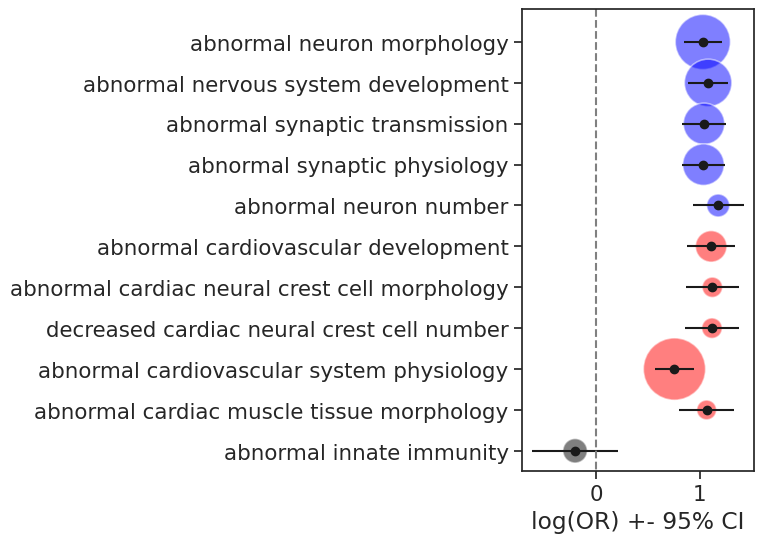

In [49]:
plt.figure(figsize=(3,6))

plt.errorbar(root_KO_df.loc[terms_plot]['log_OR'],np.arange(len(terms_plot)),
            xerr=[np.subtract(root_KO_df.loc[terms_plot]['log_OR'],root_KO_df.loc[terms_plot]['log_OR_CI_lower']),
                   np.subtract(root_KO_df.loc[terms_plot]['log_OR_CI_upper'],root_KO_df.loc[terms_plot]['log_OR'])],color='k',fmt='o')

color_temp = root_KO_df.loc[terms_plot]['MPO_term_type'].map({'brain':'blue','heart':'red','neg_ctrl':'black'})

sns.scatterplot(x=root_KO_df.loc[terms_plot]['log_OR'],
                y=np.arange(len(terms_plot)),size=root_KO_df.loc[terms_plot]['num_genes_in_term'],sizes=(200, 2000),
                alpha=.5,
               hue=color_temp.tolist(),palette={'blue':'blue','red':'red','black':'black'},legend=False)

plt.yticks(np.arange(len(terms_plot)),root_KO_df.loc[terms_plot]['MP_description'])
plt.xticks([0,1,2])
plt.xlabel('log(OR) +- 95% CI')

plt.plot([0,0],[-.8,len(terms_plot)-.5],'--',color='gray')
plt.ylim([-0.8,len(terms_plot)-.5])

plt.gca().invert_yaxis()
# plt.savefig('ASD_CHD_brain_heart_MPO_root_enrichment_210813.png',dpi=300,bbox_inches='tight')

## 18. Compute the enrichment of phenotype(s) in NetColoc subsystems.

Some phenotypes may have stronger associations with NetColoc subsystems than with the root node. In this step we calculate the enrichment of selected phenotypes in each NetColoc subsystem.


In [50]:
MP_focal_top = root_KO_df.head(10).index.tolist() # record the top 10 overall
MP_full_results_df = validation.MPO_enrichment_full(hier_df,MPO,mgi_df,MP_focal_top,G_int)
MP_full_results_df.head()

,abnormal neuron morphology:-log(OR_p),abnormal neuron morphology:log_OR,abnormal neuron morphology:num_genes,abnormal neuron morphology:gene_ids,abnormal nervous system development:-log(OR_p),abnormal nervous system development:log_OR,abnormal nervous system development:num_genes,abnormal nervous system development:gene_ids,abnormal synaptic transmission:-log(OR_p),abnormal synaptic transmission:log_OR,...,abnormal olfactory sensory neuron morphology:num_genes,abnormal olfactory sensory neuron morphology:gene_ids,abnormal neuron physiology:-log(OR_p),abnormal neuron physiology:log_OR,abnormal neuron physiology:num_genes,abnormal neuron physiology:gene_ids,abnormal neuronal precursor cell number:-log(OR_p),abnormal neuronal precursor cell number:log_OR,abnormal neuronal precursor cell number:num_genes,abnormal neuronal precursor cell number:gene_ids
C773,27.560581,1.030108,157,AFDN AFF1 AIRE ANK2 ANK3 ARID1B ATM ATP1A3 ATP...,27.034617,1.081407,136,AFDN AGO2 AIRE ANKRD17 APC ARHGEF7 ARID1A ARID...,21.754329,1.041449,...,72,AFF3 AIRE AKAP6 APC ASXL1 ATM BCL11B BRAF CACN...,17.673299,1.088803,80,AFF3 AQP4 ARHGEF2 ATM ATP1A3 BPTF BRAF BRPF1 C...,16.923890,1.450008,43,AFDN AIRE ATM BPTF BRAF BRPF1 CACNA1A CAMK2A C...
C774,6.177467,0.800908,48,AIRE ARID1B BCL11A BRD7 BRPF1 CHD7 CLOCK CREBB...,19.640454,1.362206,62,AIRE ARID1A ARID1B BCL11A BRD1 BRD2 BRPF1 CHD7...,0.764146,0.306487,...,28,AIRE ASXL1 BCL11B CHD7 CREBBP CTNNB1 DNMT3B E2...,4.044724,0.849776,24,ARHGEF2 BRPF1 CHD7 CTNNB1 EHMT2 EPAS1 FOXG1 HI...,7.120460,1.423564,16,AIRE BRPF1 CHD7 CREBBP CTNNB1 E2F5 FOXG1 GLI2 ...
C775,2.995030,0.600122,36,AFF1 ATM ATRX ATXN1 ATXN2 BPTF BRAF CDC14A CLE...,5.220398,0.827953,36,AGO2 ANKRD17 APC ARHGEF7 ATM BRAF C2CD3 CDK13 ...,2.597624,0.633985,...,19,APC ATM BRAF CDK13 DICER1 ESRP1 GOLGB1 KAT6A K...,0.553787,0.311082,13,ATM BPTF BRAF CHD8 CREB1 GSK3B KIDINS220 PTEN ...,3.556717,1.143261,11,ATM BPTF BRAF PTBP2 PTEN RBPJ RUFY3 THOC2 TSC1...
C777,23.532775,1.691589,56,ANK2 ANK3 ATP1A3 ATP1B2 CACNA1A CACNA1D CACNA1...,3.422239,0.791418,24,CACNA1A CNTN1 CNTN2 DSCAM FGFR2 ISL1 LGI1 MAPT...,28.730920,1.940990,...,18,AFF3 AKAP6 CACNA1A CAMK2A CHRNB1 FGFR2 ISL1 MA...,18.204698,1.782012,32,AFF3 AQP4 ATP1A3 CACNA1A CACNA1C CACNA1D CACNA...,4.865288,1.443117,10,CACNA1A CAMK2A MAGI2 MAPT MOG NEFM RORB SCN1B ...
C779,7.441007,1.230467,27,AFDN ATXN1 BCL11A CREBBP CTNNB1 FOXG1 FOXN4 GL...,15.843951,1.738404,33,AFDN BCL11A CREBBP CTBP1 CTBP2 CTNNB1 EP300 FO...,2.934005,0.908415,...,19,BCL11B CREBBP CTNNB1 EP300 FOXG1 FOXQ1 LEF1 NC...,4.959322,1.269431,14,CTNNB1 EPAS1 FOXG1 HDAC4 HIPK2 MYCN NCOR2 NOTC...,10.820728,2.104472,12,AFDN CREBBP CTNNB1 FOXG1 GLI2 MYCN NOTCH2 NR2F...


In [51]:
print("Top ten terms:")
print("\n".join([mp+" - "+validation.get_MP_description(mp, MPO) for mp in MP_focal_top]))

Top ten terms:
MP:0002882 - abnormal neuron morphology
MP:0003861 - abnormal nervous system development
MP:0003635 - abnormal synaptic transmission
MP:0021009 - abnormal synaptic physiology
MP:0002925 - abnormal cardiovascular development
MP:0008946 - abnormal neuron number
MP:0002206 - abnormal CNS synaptic transmission
MP:0006092 - abnormal olfactory sensory neuron morphology
MP:0004811 - abnormal neuron physiology
MP:0004979 - abnormal neuronal precursor cell number


## 19. Annotate the NetColoc systems map with mouse variant data, input genes, and enriched GO terms

In [53]:
# add the best gprofiler annotation
MP_full_results_df['gprofiler_name']=pd.Series(system_name_list,index=hier_df.index.tolist())
# don't annotate the root node
root_node = hier_df['CD_MemberList_Size'].sort_values(ascending=False).head(1).index.tolist()[0]
MP_full_results_df.loc[root_node, 'gprofiler_name']=d1_name+'-'+d2_name+' systems map'

# also add the frac_seeds/num_seeds data here
MP_full_results_df=MP_full_results_df.join(hier_df[['num_d1_seeds','num_d2_seeds','frac_d1_seeds','frac_d2_seeds','frac_both_seeds','frac_no_seeds']],
                                          how='left')

MP_full_results_df.head()

,abnormal neuron morphology:-log(OR_p),abnormal neuron morphology:log_OR,abnormal neuron morphology:num_genes,abnormal neuron morphology:gene_ids,abnormal nervous system development:-log(OR_p),abnormal nervous system development:log_OR,abnormal nervous system development:num_genes,abnormal nervous system development:gene_ids,abnormal synaptic transmission:-log(OR_p),abnormal synaptic transmission:log_OR,...,abnormal neuronal precursor cell number:log_OR,abnormal neuronal precursor cell number:num_genes,abnormal neuronal precursor cell number:gene_ids,gprofiler_name,num_d1_seeds,num_d2_seeds,frac_d1_seeds,frac_d2_seeds,frac_both_seeds,frac_no_seeds
C773,27.560581,1.030108,157,AFDN AFF1 AIRE ANK2 ANK3 ARID1B ATM ATP1A3 ATP...,27.034617,1.081407,136,AFDN AGO2 AIRE ANKRD17 APC ARHGEF7 ARID1A ARID...,21.754329,1.041449,...,1.450008,43,AFDN AIRE ATM BPTF BRAF BRPF1 CACNA1A CAMK2A C...,ASD-CHD systems map,41,23,0.053247,0.029870,0.007792,0.909091
C774,6.177467,0.800908,48,AIRE ARID1B BCL11A BRD7 BRPF1 CHD7 CLOCK CREBB...,19.640454,1.362206,62,AIRE ARID1A ARID1B BCL11A BRD1 BRD2 BRPF1 CHD7...,0.764146,0.306487,...,1.423564,16,AIRE BRPF1 CHD7 CREBBP CTNNB1 E2F5 FOXG1 GLI2 ...,PKMTs methylate histone lysines,16,7,0.058608,0.025641,0.014652,0.901099
C775,2.995030,0.600122,36,AFF1 ATM ATRX ATXN1 ATXN2 BPTF BRAF CDC14A CLE...,5.220398,0.827953,36,AGO2 ANKRD17 APC ARHGEF7 ATM BRAF C2CD3 CDK13 ...,2.597624,0.633985,...,1.143261,11,ATM BPTF BRAF PTBP2 PTEN RBPJ RUFY3 THOC2 TSC1...,Chromatin modifying enzymes,9,7,0.037344,0.029046,0.008299,0.925311
C777,23.532775,1.691589,56,ANK2 ANK3 ATP1A3 ATP1B2 CACNA1A CACNA1D CACNA1...,3.422239,0.791418,24,CACNA1A CNTN1 CNTN2 DSCAM FGFR2 ISL1 LGI1 MAPT...,28.730920,1.940990,...,1.443117,10,CACNA1A CAMK2A MAGI2 MAPT MOG NEFM RORB SCN1B ...,Ion homeostasis,12,6,0.072727,0.036364,0.000000,0.890909
C779,7.441007,1.230467,27,AFDN ATXN1 BCL11A CREBBP CTNNB1 FOXG1 FOXN4 GL...,15.843951,1.738404,33,AFDN BCL11A CREBBP CTBP1 CTBP2 CTNNB1 EP300 FO...,2.934005,0.908415,...,2.104472,12,AFDN CREBBP CTNNB1 FOXG1 GLI2 MYCN NOTCH2 NR2F...,Gastrulation,6,5,0.055046,0.045872,0.009174,0.889908


## 20. Export the NetColoc systems map to NDEx, with default style. 

Default style maps the fraction of seed genes from input set 1 (red) and input set 2 (blue) to node pie charts. The fraction of genes in each system that are in neither input set, but that are implicated by the network propagation are indicated in white.

In [54]:
G_hier_export = G_hier.copy()

In [55]:
# Convert G_hier to nice cx network
node_id_to_node_name = nx.get_node_attributes(G_hier, 'name')
for node_id in list(G_hier.nodes):
    del G_hier_export.nodes[node_id]['name']

G_hier_cx = ndex2.create_nice_cx_from_networkx(G_hier_export)

for node_id, node in G_hier_cx.get_nodes():
    node['n'] = node_id_to_node_name[node_id]

G_hier_cx.set_name(d1_name+'_'+d2_name+'_systems_map') 
for node_id, node in G_hier_cx.get_nodes():
    data = MP_full_results_df.loc[node['r']]
    for row, value in data.items():
        if (row.find('gene_ids')>-1) or (row=='gprofiler_name'):
            data_type = "string"
            value=str(value)
        else:
            data_type = "double"
            value = str(value) # nice cx can only accept strings as values...
            if value=='inf': # check if inf, set to -1 if so
                value='-1'
            
        G_hier_cx.set_node_attribute(node_id, row, value, type=data_type)

# Restore some hierarchy properties to their state before networkx conversion.
for node_id, node in G_hier_cx.get_nodes():
    for i in np.arange(len(G_hier_cx.nodeAttributes[node_id])):
        dict_temp = G_hier_cx.nodeAttributes[node_id][i]
        if dict_temp['n'] in ['CD_MemberList_Size','CD_MemberList_LogSize','HiDeF_persistence']:
            G_hier_cx.set_node_attribute(node_id, dict_temp['n'], dict_temp['v'], type='double',overwrite=True)
            
# this is required so we can easily make subgraphs from systems
G_hier_cx.set_network_attribute('__CD_OriginalNetwork',
                                       values='0', type='long')
            
          
# use apply_style_from_network-- this should overwrite the existing style
netcoloc_template = ndex2.create_nice_cx_from_server('public.ndexbio.org',
            uuid='f338dea0-117c-11ec-9e8e-0ac135e8bacf')
G_hier_cx.apply_style_from_network(netcoloc_template)

In [ ]:
#Upload to NDEx. Enter your ndex username and password. 
# If you are new to ndex, make a new account on the website (ndexbio.org)
G_hier_cx.set_name(d1_name+'_'+d2_name+'_systems_map') 
SERVER = input('NDEx server (probably public.ndexbio.org): ')
USERNAME = input('NDEx user name: ')
PASSWORD = getpass.getpass('NDEx password: ')
network_uuid_hier = G_hier_cx.upload_to(SERVER, USERNAME, PASSWORD)

## 21. Apply another template style to NetColoc systems map for mouse knockout view, and export to NDEx. 

Select the property to be mapped to system node colors (should be one of the mouse knockout phenotypes we identified above). In this style, the log odds ratio is mapped to the system node color. Systems which are not significantly enriched for the phenotype are white (p<0.05).


In [57]:
# ------ modify this based on your project. Should be a system identified above -----
# set the property we should map to system node colors
mouse_KO_mapping_property = 'abnormal neuron morphology'

In [58]:
# apply a template style 
G_hier_cx.set_name(d1_name+'_'+d2_name+'_systems_map_mouse_KO:'+mouse_KO_mapping_property) 
# use apply_style_from_network-- this should overwrite existing style
netcoloc_template = ndex2.create_nice_cx_from_server('ndexbio.org',
            uuid='4958993c-df46-11eb-b666-0ac135e8bacf')
raw_cx_st = json.dumps(netcoloc_template.to_cx())

# replace the default template values with mouse_KO_mapping_property
updated_raw_cx = re.sub('COL=abnormal heart development:log_OR', 'COL='+mouse_KO_mapping_property+':log_OR', raw_cx_st)
updated_raw_cx = re.sub('COL=abnormal heart development:-log', 
                        'COL='+mouse_KO_mapping_property+':-log', updated_raw_cx)
updated_raw_cx=json.loads(updated_raw_cx)
netcoloc_template_updated = ndex2.create_nice_cx_from_raw_cx(updated_raw_cx)
G_hier_cx.apply_style_from_network(netcoloc_template_updated)

network_uuid_hier_mouse_KO = G_hier_cx.upload_to(SERVER, USERNAME, PASSWORD)

Generating CX
Generating CX


## 22. Add genes associated with mouse variant phenotypes to NetColoc subnetwork, export to NDEx. 

In [59]:
# add fields to node_df for genes in each mouse_KO phenotype of interest
MP_genes_columns = [c for c in MP_full_results_df.columns.tolist() if c.find(':gene_ids')>-1]

# look up overlapping genes in the root node, add them to node_df
for MP in MP_genes_columns:
    focal_genes = MP_full_results_df.loc[root_node, MP].split(' ')
    node_df[MP]=0
    node_df.loc[focal_genes, MP]=1
node_df.head()

,d1_seeds,d2_seeds,d1_name,d2_name,z_d1,z_d2,z_both,sum_seeds,abnormal neuron morphology:gene_ids,abnormal nervous system development:gene_ids,abnormal synaptic transmission:gene_ids,abnormal synaptic physiology:gene_ids,abnormal cardiovascular development:gene_ids,abnormal neuron number:gene_ids,abnormal CNS synaptic transmission:gene_ids,abnormal olfactory sensory neuron morphology:gene_ids,abnormal neuron physiology:gene_ids,abnormal neuronal precursor cell number:gene_ids
PTEN,1,1,ASD,CHD,17.775818,18.270646,324.775666,2,1,1,1,1,1,1,1,1,1,1
CTNNB1,1,1,ASD,CHD,15.369891,16.212593,249.185790,2,1,1,1,1,1,1,1,1,1,1
POGZ,1,1,ASD,CHD,12.518539,13.035299,163.182897,2,1,0,1,1,0,0,1,0,0,0
KMT2C,1,1,ASD,CHD,12.964197,12.579514,163.083297,2,0,0,0,0,0,0,0,0,0,0
NSD1,1,1,ASD,CHD,12.263667,12.748115,156.338630,2,0,0,0,0,0,0,0,0,0,0


In [60]:

G_overlap_cx = ndex2.create_nice_cx_from_networkx(G_overlap)
G_overlap_cx.set_name(d1_name+'_'+d2_name+'_NetColoc_subgraph') 
for node_id, node in G_overlap_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_overlap_cx.set_node_attribute(node_id, row, value, type=data_type)

# apply a template style (834b6ad4-d2ea-11eb-b666-0ac135e8bacf)
G_overlap_cx.apply_template('ndexbio.org','834b6ad4-d2ea-11eb-b666-0ac135e8bacf')

network_uuid_NetColoc = G_overlap_cx.upload_to(SERVER, USERNAME, PASSWORD)

Generating CX


## 23. Upload cosine-similarity transformed NetColoc subnetwork to NDEx

In [61]:
#Annotate network
print("Number of nodes in cosine similarity network:", len(G_cosSim.nodes()))
print("Number of edges in cosine similarity network:", len(G_cosSim.edges()))
G_cosSim_cx = ndex2.create_nice_cx_from_networkx(G_cosSim)
G_cosSim_cx.set_name(d1_name+'_'+d2_name+'_NetColoc_subgraph_CosSim95') 
for node_id, node in G_cosSim_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_cosSim_cx.set_node_attribute(node_id, row, value, type=data_type)
        
        

# apply a template style (834b6ad4-d2ea-11eb-b666-0ac135e8bacf)
G_cosSim_cx.apply_template('ndexbio.org','2cbed84b-e5c3-11eb-b666-0ac135e8bacf')

network_uuid_NetColoc_CosSim = G_cosSim_cx.upload_to(SERVER, USERNAME, PASSWORD)

Number of nodes in cosine similarity network: 773
Number of edges in cosine similarity network: 7861
Generating CX


## 24. Add 4 networks from above to network set

In [62]:
# append the datestring to the network set to guarantee uniqueness
datestr = str(datetime.now())
networkSetURL=ndex2.client.Ndex2(host=SERVER,username=USERNAME,password=PASSWORD).create_networkset(d1_name+'-'+d2_name+' network set: '+datestr,'network set for '+d1_name+'-'+d2_name+' NetColoc subgraph and systems map')
networkSetURL

'https://www.ndexbio.org/v2/networkset/14321ea8-8735-11ef-af07-005056ae3c32'

In [63]:
# parse out UUID from URL strings
networkSetUUID = networkSetURL.split('/')[-1]
networkSetUUID

networkURLs = [network_uuid_NetColoc,network_uuid_NetColoc_CosSim,network_uuid_hier,network_uuid_hier_mouse_KO]
networkUUIDs = [n.split('/')[-1] for n in networkURLs]

ndex2.client.Ndex2(host=SERVER,username=USERNAME,password=PASSWORD).add_networks_to_networkset(networkSetUUID,
                                                                                              networkUUIDs)


'https://www.ndexbio.org/v2/networkset/14321ea8-8735-11ef-af07-005056ae3c32/members'